In [1]:
### LLM
from langchain_ollama import ChatOllama

local_llm = "llama3.2:3b-instruct-fp16"
llm = ChatOllama(model=local_llm, temperature=0)

llm_json_mode = ChatOllama(model=local_llm, temperature=0, format="json")


In [2]:
## Optionally

import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")
_set_env("LANGCHAIN_API_KEY")

os.environ['TOKENIZERS_PARALLELISM'] = 'true'
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "local-llama32-rag"

### Search
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(k=3)


TAVILY_API_KEY:  ········
LANGCHAIN_API_KEY:  ········


In [52]:
docs = web_search_tool.invoke({"query": "火災時該如何？"})
print("====== docs ======", docs)

====== docs ====== [{'url': 'https://www.businessweekly.com.tw/style/blog/3000029', 'content': '發現火災時，父親一心急著下樓逃生，5歲小兒子見狀也跟著下樓，留下一位6歲大的兒子還在火場。 ... 不是不該，而是因為火災的每分每秒都在和死神拔河，所以各項行動都有先後次序。 ... 他同時訓練消防人員如何跟民眾用白話講專業，並引發聽眾動機、實際 ...'}, {'url': 'https://yimedia.com.tw/lifestyle/594699/', 'content': '小; 中; 大; 消防局指出，遇到火災時，應立即以關門、避難或逃生為最高原則。（示意圖／翻攝Pexels） 新竹東區慈雲路28樓社區大樓「晴空匯」於26日深夜發生火警，導致大樓共351名住戶受困，消防人員耗時10餘小時全數救出，也讓民眾擔憂發生火災到底該如何自救，過去台南市消防局也曾宣導火場 ...'}, {'url': 'https://today.line.me/tw/v2/article/9lyK3r', 'content': '逃生時低姿勢該怎麼做？ 【求生隨堂考】 在學校時，你一定聽老師們說過：「遇到火災時切勿驚慌，應該保持鎮定，並採取低姿勢逃生。」聽起來好像很容易，就你的理解，低姿勢應該怎麼做才對？ a.跪地手掌撐地爬行。 b.如行軍般匍匐前進。'}, {'url': 'https://www.fetnet.net/content/cbu/tw/lifecircle/topics/2022/03/fire_escape.html', 'content': '如果不幸遇到火災，當下應該要怎麼做呢？ ... 換新iPhone 16資料備份、轉移該怎麼用？ ... 另外，平時就應規劃兩個方向逃生路線，當主要逃生出口無法往下或往外逃生時，就必須尋找第二逃生出口，若第二逃生出口也受阻礙，則改往火、煙、熱反方向的空間避難 ...'}, {'url': 'https://www.youtube.com/watch?v=99TERJ5MDSo', 'content': '發生火災的第一時間，到底應該怎麼辦呢!？第一步就是先示警家人，大聲呼喊『失火了!』，讓家人先從主要出入口逃生，或是前往相對安全區 

In [ ]:
### Load data
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_nomic.embeddings import NomicEmbeddings
import glob
import os
from langchain.document_loaders import JSONLoader

DATA_PATH = "data/"

def load_documents():
    # Path to the folder containing your JSON files
    folder_path = DATA_PATH
    json_files = glob.glob(os.path.join(folder_path, "*.json"))

    documents = []  # List to hold all document data
    for file in json_files:
        loader = JSONLoader(
            file_path=file,
            jq_schema=".[].content",
        )
        loaded_documents = loader.load()
        documents.extend(loaded_documents)

    return documents


# Load documents
# Create (or update) the data store.
docs_list = load_documents()
print(len(docs_list))


In [14]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=2000, chunk_overlap=200
)
doc_splits = text_splitter.split_documents(docs_list)

In [16]:
# Add to vectorDB
vectorstore = SKLearnVectorStore.from_documents(
    documents=doc_splits,
    embedding=NomicEmbeddings(model="nomic-embed-text-v1.5", inference_mode="local"),
)

# Create retriever
retriever = vectorstore.as_retriever(k=3)

In [18]:
retriever.invoke("火災")

[Document(metadata={'id': '712c1ea2-790a-4b40-9c48-fb9e396b43cf', 'source': '/Users/davis_chang/code/project/llm-rag-pdf-image-markdown/local-adaptive-rag-llama3/data/finance.ettoday.net_2024-09-03.json', 'seq_num': 51}, page_content='▲鍋子火勢甚至越來越旺「發爐」，讓女主播嚇到花容失色，不斷驚聲尖叫。（翻自X平台） 圖文／鏡週刊 美國佛羅里達一名女直播主，近日在進行色色廚房的直播拍攝時，突然瞬間變成火警現場，讓網友與粉絲都嚇壞。 影片可見，女直播主穿著性感清涼，進行「色色廚房」拍攝，但不知為何鍋子突然燒起來，火勢甚至越來越旺「發爐」，讓女主播嚇到花容失色，不斷驚聲尖叫。旁邊一名男性工作人員發現狀況不對，跑過來幫忙，但他們沒有使用滅火器，而是打開流理台下方櫃子，之後男子把燒起來的鍋子，直接丟進流理台下方。 ▲鍋子的火勢一發不可收拾。（翻自X平台） 這時鏡頭沒有再看到火苗竄出，燒紅的電磁爐具也沒再冒出大火。但女主播依舊驚魂未定，不斷呼喊「歐買尬」，最後要求男子把大門打開，影片也到此結束。這段18禁情色廚房秒變恐怖火警的片段，隨即被網友們傳開並熱議，網友們也直呼：「好恐怖！」、「注意安全是最重要的。」、「這樣滅火方法對嗎？」、「為何不先關火？」 美国????????直播主，做饭的时候几乎烧毁了她的厨房和公寓。 pic.twitter.com/vAygvj27Ly 更多鏡週刊報導 為流量不要命 又一中國重機正妹車禍慘死！曾炫耀時速飆265公里 【41J肉聲】厲害了中國女三寶！逆向撞車還連搧對方10巴掌 身分被起底 不是鬼片！日本防範珊珊颱風拆坂本龍馬雕像 畫面太詭異引熱議 分享給朋友： 追蹤我們：'),
 Document(metadata={'id': 'c8371a5d-ae6b-4902-8e89-9c7042037e41', 'source': '/Users/davis_chang/code/project/llm-rag-pdf-image-markdown/local-adaptive-rag-llama3/data/finan

In [19]:
### Router
import json
from langchain_core.messages import HumanMessage, SystemMessage

# Prompt
router_instructions = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. For all else, and especially for current events, use web-search.
Return JSON with a single key, datasource, that is 'websearch' or 'vectorstore' depending on the question."""

question = [HumanMessage(content="What are the types of agent memory?")]
test_vector_store = llm_json_mode.invoke([SystemMessage(content=router_instructions)] + question)
json.loads(test_vector_store.content)

{'datasource': 'vectorstore'}

In [22]:
### Retrieval Grader

# Doc grader instructions
doc_grader_instructions = """You are a grader assessing relevance of a retrieved document to a user question.
If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant."""

# Grader prompt
doc_grader_prompt = """Here is the retrieved document: \n\n {document} \n\n Here is the user question: \n\n {question}.
Carefully and objectively assess whether the document contains at least some information that is relevant to the question.
Return JSON with single key, binary_score, that is 'yes' or 'no' score to indicate whether the document contains at least some information that is relevant to the question."""

# Test
question = "火災該做什麼?"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
doc_grader_prompt_formatted = doc_grader_prompt.format(document=doc_txt, question=question)
result = llm_json_mode.invoke([SystemMessage(content=doc_grader_instructions)] + [HumanMessage(content=doc_grader_prompt_formatted)])
json.loads(result.content)

{'binary_score': 'yes'}

In [23]:
doc_txt

'▲台南歸仁塑膠廠大火。（圖／民眾提供） 記者鄒鎮宇／綜合報導 海屏企業有限公司位於台南市歸仁區長榮路的塑膠粒倉庫，22日晚間突然起火燃燒，300坪廠房全面燃燒，黑煙不斷沖天、發出惡臭。警消獲報後，立刻出動大批人力前往灌救，目前無人受困，起火原因仍在釐清。 台南市消防局22日深夜11時7分獲報，該占地300坪的廠房不明原因起火，立刻出動18車39人前往灌救，現場不斷傳出惡臭。另外，海屏企業負責人也於深夜11時41分到場，同時警消確認場內無人受困。 消防局表示，目前建立循環式送水，第2、3、4面都是農田不會延燒，第1面已架設3線砲塔防護，起火原因仍在釐清。 ▲▼台南歸仁塑膠廠大火。（圖／民眾提供） 臉書粉專「台南式 Tainan Style」表示，工廠發生大火後，濃煙不斷竄出擴散，請附近仁德、歸仁，高鐵站、長榮大學周圍的居民注意空氣品質。 網友看完紛紛留言，「難怪一直聽到消防車的警鳴聲」、「台南最近太常火災了」、「拜託警消醫護人員你們不要受傷，現場請尊重專業」、「難怪歸仁這邊都有個味道想說有人在燒雜草」、「23:17接獲通報，現在24:00還在搶救中」、「啊怎麼又是那附近」、「火好大」。 歸仁區長榮路 希望大家平安 深夜火警，仁德服務區旁工廠發生大火，請仁德、歸仁，高鐵站、長榮大學周邊居民注意空氣品質 ►按這訂閱Podcast《小編沒收工》每天熱門話題聊不完 分享給朋友： 追蹤我們：'

In [24]:
docs

[Document(metadata={'id': '712c1ea2-790a-4b40-9c48-fb9e396b43cf', 'source': '/Users/davis_chang/code/project/llm-rag-pdf-image-markdown/local-adaptive-rag-llama3/data/finance.ettoday.net_2024-09-03.json', 'seq_num': 51}, page_content='▲鍋子火勢甚至越來越旺「發爐」，讓女主播嚇到花容失色，不斷驚聲尖叫。（翻自X平台） 圖文／鏡週刊 美國佛羅里達一名女直播主，近日在進行色色廚房的直播拍攝時，突然瞬間變成火警現場，讓網友與粉絲都嚇壞。 影片可見，女直播主穿著性感清涼，進行「色色廚房」拍攝，但不知為何鍋子突然燒起來，火勢甚至越來越旺「發爐」，讓女主播嚇到花容失色，不斷驚聲尖叫。旁邊一名男性工作人員發現狀況不對，跑過來幫忙，但他們沒有使用滅火器，而是打開流理台下方櫃子，之後男子把燒起來的鍋子，直接丟進流理台下方。 ▲鍋子的火勢一發不可收拾。（翻自X平台） 這時鏡頭沒有再看到火苗竄出，燒紅的電磁爐具也沒再冒出大火。但女主播依舊驚魂未定，不斷呼喊「歐買尬」，最後要求男子把大門打開，影片也到此結束。這段18禁情色廚房秒變恐怖火警的片段，隨即被網友們傳開並熱議，網友們也直呼：「好恐怖！」、「注意安全是最重要的。」、「這樣滅火方法對嗎？」、「為何不先關火？」 美国????????直播主，做饭的时候几乎烧毁了她的厨房和公寓。 pic.twitter.com/vAygvj27Ly 更多鏡週刊報導 為流量不要命 又一中國重機正妹車禍慘死！曾炫耀時速飆265公里 【41J肉聲】厲害了中國女三寶！逆向撞車還連搧對方10巴掌 身分被起底 不是鬼片！日本防範珊珊颱風拆坂本龍馬雕像 畫面太詭異引熱議 分享給朋友： 追蹤我們：'),
 Document(metadata={'id': '915f1092-6a51-4549-8848-6824e52b1c93', 'source': '/Users/davis_chang/code/project/llm-rag-pdf-image-markdown/local-adaptive-rag-llama3/data/finan

In [25]:
### Generate

# Prompt
rag_prompt = """You are an assistant for question-answering tasks.
Here is the context to use to answer the question:
{context}

Think carefully about the above context.
Now, review the user question:
{question}

Provide an answer to this question using only the above context.
Use three sentences maximum and keep the answer concise.
Answer:"""

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Test
docs = retriever.invoke(question)
docs_txt = format_docs(docs)
rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=question)
generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
print(generation.content)

如果是在台灣遇到火警，應該立即呼叫119或其他緊急服務號碼，然後迅速離開火災區域，找到安全的地方等待救援。不要試圖自行撲滅火災，也不 nên使用濕毛巾遮口鼻或塑膠袋套頭。同時，應該記住「5不1原則」，即不要進入火災區域，不要用電器，不要穿著可燃物、不 nên吸菸等。


In [29]:
docs_txt

'▲鍋子火勢甚至越來越旺「發爐」，讓女主播嚇到花容失色，不斷驚聲尖叫。（翻自X平台） 圖文／鏡週刊 美國佛羅里達一名女直播主，近日在進行色色廚房的直播拍攝時，突然瞬間變成火警現場，讓網友與粉絲都嚇壞。 影片可見，女直播主穿著性感清涼，進行「色色廚房」拍攝，但不知為何鍋子突然燒起來，火勢甚至越來越旺「發爐」，讓女主播嚇到花容失色，不斷驚聲尖叫。旁邊一名男性工作人員發現狀況不對，跑過來幫忙，但他們沒有使用滅火器，而是打開流理台下方櫃子，之後男子把燒起來的鍋子，直接丟進流理台下方。 ▲鍋子的火勢一發不可收拾。（翻自X平台） 這時鏡頭沒有再看到火苗竄出，燒紅的電磁爐具也沒再冒出大火。但女主播依舊驚魂未定，不斷呼喊「歐買尬」，最後要求男子把大門打開，影片也到此結束。這段18禁情色廚房秒變恐怖火警的片段，隨即被網友們傳開並熱議，網友們也直呼：「好恐怖！」、「注意安全是最重要的。」、「這樣滅火方法對嗎？」、「為何不先關火？」 美国????????直播主，做饭的时候几乎烧毁了她的厨房和公寓。 pic.twitter.com/vAygvj27Ly 更多鏡週刊報導 為流量不要命 又一中國重機正妹車禍慘死！曾炫耀時速飆265公里 【41J肉聲】厲害了中國女三寶！逆向撞車還連搧對方10巴掌 身分被起底 不是鬼片！日本防範珊珊颱風拆坂本龍馬雕像 畫面太詭異引熱議 分享給朋友： 追蹤我們：\n\n▲台南歸仁塑膠廠大火。（圖／民眾提供） 記者鄒鎮宇／綜合報導 海屏企業有限公司位於台南市歸仁區長榮路的塑膠粒倉庫，22日晚間突然起火燃燒，300坪廠房全面燃燒，黑煙不斷沖天、發出惡臭。警消獲報後，立刻出動大批人力前往灌救，目前無人受困，起火原因仍在釐清。 台南市消防局22日深夜11時7分獲報，該占地300坪的廠房不明原因起火，立刻出動18車39人前往灌救，現場不斷傳出惡臭。另外，海屏企業負責人也於深夜11時41分到場，同時警消確認場內無人受困。 消防局表示，目前建立循環式送水，第2、3、4面都是農田不會延燒，第1面已架設3線砲塔防護，起火原因仍在釐清。 ▲▼台南歸仁塑膠廠大火。（圖／民眾提供） 臉書粉專「台南式 Tainan Style」表示，工廠發生大火後，濃煙不斷竄出擴散，請附近仁德、歸仁，高鐵站、長榮大學周圍的居民注意空氣品質。 網友看完紛紛留言，「難怪一直聽到消防車的警鳴聲」、「台南最近太常火

In [26]:
question

'火災該做什麼?'

In [30]:
### Hallucination Grader

# Hallucination grader instructions
hallucination_grader_instructions = """
You are a teacher grading a quiz.
You will be given FACTS and a STUDENT ANSWER.

Here is the grade criteria to follow:
(1) Ensure the STUDENT ANSWER is grounded in the FACTS.
(2) Ensure the STUDENT ANSWER does not contain "hallucinated" information outside the scope of the FACTS.

Score:
A score of yes means that the student's answer meets all of the criteria. This is the highest (best) score.
A score of no means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct.
Avoid simply stating the correct answer at the outset."""

# Grader prompt
hallucination_grader_prompt = """FACTS: \n\n {documents} \n\n STUDENT ANSWER: {generation}.

Return JSON with two keys, binary_score is 'yes' or 'no' score to indicate whether the STUDENT ANSWER is grounded in the FACTS. And a key, explanation, with step-by-step reasoning."""

# Test using documents and generation from above
hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(documents=docs_txt, generation=generation.content)
result = llm_json_mode.invoke([SystemMessage(content=hallucination_grader_instructions)] + [HumanMessage(content=hallucination_grader_prompt_formatted)])
json.loads(result.content)

{'binary_score': 'yes',
 'explanation': '如果是在台灣遇到火警，應該立即呼叫119或其他緊急服務號碼，然後迅速離開火災區域，找到安全的地方等待救援。這是正確的逃生方法，因為它能夠快速地將人們移出火災區域，減少受傷風險。\n\n另外，記住 "5不1原則"，即不要進入火災區域，不要用電器，不要穿著可燃物、不 nên吸菸等，這些都是防止自己或他人在火災中受傷的重要措施。'}

In [31]:
### Answer Grader

# Answer grader instructions
answer_grader_instructions = """You are a teacher grading a quiz.
You will be given a QUESTION and a STUDENT ANSWER.

Here is the grade criteria to follow:
(1) The STUDENT ANSWER helps to answer the QUESTION.

Score:
A score of yes means that the student's answer meets all of the criteria. This is the highest (best) score.
The student can receive a score of yes if the answer contains extra information that is not explicitly asked for in the question.
A score of no means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct.
Avoid simply stating the correct answer at the outset."""

# Grader prompt
answer_grader_prompt = """QUESTION: \n\n {question} \n\n STUDENT ANSWER: {generation}.

Return JSON with two keys, binary_score is 'yes' or 'no' score to indicate whether the STUDENT ANSWER meets the criteria. And a key, explanation, with step-by-step reasoning."""

# Test
question = "火警找濕毛巾遮口鼻、用塑膠袋套頭、躲在浴室?"
answer = "內政部指出，過去坊間流傳遇到火警找濕毛巾遮口鼻、用塑膠袋套頭、躲在浴室等，都是錯誤的逃生觀念"

# Test using question and generation from above
answer_grader_prompt_formatted = answer_grader_prompt.format(question=question, generation=answer)
result = llm_json_mode.invoke([SystemMessage(content=answer_grader_instructions)] + [HumanMessage(content=answer_grader_prompt_formatted)])
json.loads(result.content)

{'binary_score': 'yes',
 'explanation': ['Step 1: ตรวจสอบ是否回答了問題的主要內容。',
  'Student Answer 回答了問題的主要內容，即火警時應該如何逃生，特別是關於使用濕毛巾、塑膠袋和浴室的建議。',
  'Step 2: ตรวจสอบ是否正確反映了指南或建議。',
  'Student Answer 提到內政部的指南，強調過去的逃生觀念是錯誤的，這符合問題要求，回答了關於火警時應該如何逃生的建議。',
  'Step 3: ตรวจสอบ是否提供了額外信息。',
  'Student Answer 不僅回答了問題的主要內容，也提到了過去的錯誤觀念，這是一個額外的信息，但它仍然符合問題要求，回答了關於火警時應該如何逃生的建議。']}

In [32]:
answer_grader_prompt_formatted

"QUESTION: \n\n 火警找濕毛巾遮口鼻、用塑膠袋套頭、躲在浴室? \n\n STUDENT ANSWER: 內政部指出，過去坊間流傳遇到火警找濕毛巾遮口鼻、用塑膠袋套頭、躲在浴室等，都是錯誤的逃生觀念.\n\nReturn JSON with two keys, binary_score is 'yes' or 'no' score to indicate whether the STUDENT ANSWER meets the criteria. And a key, explanation, with step-by-step reasoning."

In [33]:
# GraphState: This class is a specialized dictionary (TypedDict) that defines the structure of
# data related to the state of a graph used in processing LLM (Large Language Model) outputs and decisions.
import operator
from typing_extensions import TypedDict
from typing import List, Annotated

class GraphState(TypedDict):
    """
    Graph state is a dictionary that contains information we want to propagate to, and modify in, each graph node.
    """
    question: str # User question
    generation: str # LLM generation
    web_search: str # Binary decision to run web search
    max_retries: int # Max number of retries for answer generation
    answers: int # Number of answers generated
    loop_step: Annotated[int, operator.add]
    documents: List[str] # List of retrieved documents

In [48]:
from langchain.schema import Document
from langgraph.graph import END

### Nodes
def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Write retrieved documents to documents key in state
    documents = retriever.invoke(question)
    return {"documents": documents}

def generate(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    loop_step = state.get("loop_step", 0)
    
    # RAG generation
    docs_txt = format_docs(documents)
    rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {"generation": generation, "loop_step": loop_step+1}

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    
    # Score each doc
    filtered_docs = []
    web_search = "No" 
    for d in documents:
        doc_grader_prompt_formatted = doc_grader_prompt.format(document=d.page_content, question=question)
        result = llm_json_mode.invoke([SystemMessage(content=doc_grader_instructions)] + [HumanMessage(content=doc_grader_prompt_formatted)])
        grade = json.loads(result.content)['binary_score']
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "web_search": web_search}
    
def web_search(state):
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state.get("documents", [])

    # Web search
    docs = web_search_tool.invoke({"query": question})
    print("====== docs ======", docs)
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)
    return {"documents": documents}

### Edges

def route_question(state):
    """
    Route question to web search or RAG 

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    route_question = llm_json_mode.invoke([SystemMessage(content=router_instructions)] + [HumanMessage(content=state["question"])])
    source = json.loads(route_question.content)['datasource']
    if source == 'websearch':
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    elif source == 'vectorstore':
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    web_search = state["web_search"]
    filtered_documents = state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: NOT ALL DOCUMENTS ARE RELEVANT TO QUESTION, INCLUDE WEB SEARCH---")
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]
    max_retries = state.get("max_retries", 3) # Default to 3 if not provided

    hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(documents=format_docs(documents), generation=generation.content)
    result = llm_json_mode.invoke([SystemMessage(content=hallucination_grader_instructions)] + [HumanMessage(content=hallucination_grader_prompt_formatted)])
    grade = json.loads(result.content)['binary_score']

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        # Test using question and generation from above 
        answer_grader_prompt_formatted = answer_grader_prompt.format(question=question, generation=generation.content)
        result = llm_json_mode.invoke([SystemMessage(content=answer_grader_instructions)] + [HumanMessage(content=answer_grader_prompt_formatted)])
        grade = json.loads(result.content)['binary_score']
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        elif state["loop_step"] <= max_retries:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
        else:
            print("---DECISION: MAX RETRIES REACHED---")
            return "max retries"  
    elif state["loop_step"] <= max_retries:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"
    else:
        print("---DECISION: MAX RETRIES REACHED---")
        return "max retries"

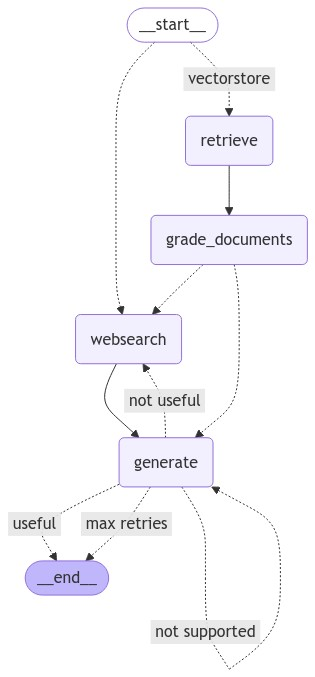

In [49]:
from langgraph.graph import StateGraph
from IPython.display import Image, display

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("websearch", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generate

# Build graph
workflow.set_conditional_entry_point(
    route_question,
    {
        "websearch": "websearch",
        "vectorstore": "retrieve",
    },
)

workflow.add_edge("websearch", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)

workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "websearch",
        "max retries": END,
    },
)

# Compile
graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))



In [50]:
inputs = {'question': "火災時該如何？", "max_retries": 3}
for event in graph.stream(inputs, stream_mode="values"):
    print(event)

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
{'question': '火災時該如何？', 'max_retries': 3, 'loop_step': 0}
---WEB SEARCH---
====== docs ====== [{'url': 'https://yimedia.com.tw/lifestyle/594699/', 'content': '小; 中; 大; 消防局指出，遇到火災時，應立即以關門、避難或逃生為最高原則。（示意圖／翻攝Pexels） 新竹東區慈雲路28樓社區大樓「晴空匯」於26日深夜發生火警，導致大樓共351名住戶受困，消防人員耗時10餘小時全數救出，也讓民眾擔憂發生火災到底該如何自救，過去台南市消防局也曾宣導火場 ...'}, {'url': 'https://www.ettoday.net/news/20240528/2747382.htm', 'content': '消防局指出，遇到火災時，應立即以關門、避難或逃生為最高原則。（示意圖／翻攝Pexels） 圖文／CTWANT. 新竹東區慈雲路28樓社區大樓「晴空匯」於26 ...'}, {'url': 'https://today.line.me/tw/v2/article/9lyK3r', 'content': '逃生時低姿勢該怎麼做？ 【求生隨堂考】 在學校時，你一定聽老師們說過：「遇到火災時切勿驚慌，應該保持鎮定，並採取低姿勢逃生。」聽起來好像很容易，就你的理解，低姿勢應該怎麼做才對？ a.跪地手掌撐地爬行。 b.如行軍般匍匐前進。'}, {'url': 'https://www.tfdp.com.tw/cht/index.php?code=list&ids=17', 'content': '火災 知識. 關於火災小常識，你知道多少呢？該如何防範火災的發生？火災時如何緊急應變？災後處理一次告訴你，讓你成為 ...'}, {'url': 'https://www.youtube.com/watch?v=99TERJ5MDSo', 'content': '發生火災的第一時間，到底應該怎麼辦呢!？第一步就是先示警家人，大聲呼喊『失火了!』，讓家人先從主要出入口逃生，或是前往相對安全區 ...'}]
{'quest

In [38]:
# Test on current events
inputs = {"question": "火災時不可搭乘電梯逃生？", "max_retries": 3}
for event in graph.stream(inputs, stream_mode="values"):
    print(event)

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
{'question': '火災時不可搭乘電梯逃生？', 'max_retries': 3, 'loop_step': 0}
---RETRIEVE---
{'question': '火災時不可搭乘電梯逃生？', 'max_retries': 3, 'loop_step': 0, 'documents': [Document(metadata={'id': 'f6ef05bd-2bc9-45bf-a34f-32a142585118', 'source': '/Users/davis_chang/code/project/llm-rag-pdf-image-markdown/local-adaptive-rag-llama3/data/news.ebc.net.tw_2024-08-23.json', 'seq_num': 58}, page_content='逃生6要訣 內政部指出，過去坊間流傳遇到火警找濕毛巾遮口鼻、用塑膠袋套頭、躲在浴室等，都是錯誤的逃生觀念，若不幸遇到火警，請記得「5不1原則」的應變逃生6要訣： 一、 不可為了收拾財物而延誤逃生避難時間，應以保命求生為首要目標。 二、 不可搭乘電梯逃生：火場易斷電，會受困在電梯內。 三、 不可躲在浴室：火場危害主要為濃煙，浴室門及天花板大多為塑膠材質，不耐高溫，且門下方為通風百葉，無法有效阻絕濃煙危害。 四、 不可用塑膠袋套頭：除無法裝到新鮮空氣，且呼吸產生的霧氣，會影響逃生視線及速度，若遇火場高溫，塑膠袋也會熔化而黏在皮膚上。 五、 不可浪費時間尋找濕毛巾而延誤逃生避難：濕毛巾擋不住濃煙中的一氧化碳和有毒氣體，且尋找濕毛巾恐延誤逃生時間。 六、 火場逃生避難流程原則 (一) 平時規劃2個逃生出口。 (二) 火災時，應往1樓往外逃生，逃生避難時，一定要謹記隨手關門。 (三) 往1樓往外逃生時，若主要逃生路徑外已有濃煙無法避難時，請尋找第2逃生路徑往1樓往外逃生；若第2逃生路徑也受阻礙，則改往未起火相對安全空間關門避難，並用衣物或毛巾將門縫塞住，防止煙霧流入，並撥打119求援，詳細告知待救人員的所在位置，等待消防人員救援。 內政部強調，火場無情，惟有強化自身火災預防及應變知識，平時謹記逃生避難原則，才能保障生命財產的

====== docs ====== HTTPError('400 Client Error: Bad Request for url: https://api.tavily.com/search')
